In [1]:
using Revise
# Tensor_trains 
using TensorTrains, TensorCast, Tullio, LogarithmicNumbers, ProgressMeter, LinearAlgebra
using TensorTrains: compress, TruncBondThresh  

# MonteCarlo
using Random, Statistics, Distributions

# Graphics
using Plots, Colors

includet("tensor_builder.jl")
includet("calculo_observables.jl")
includet("monte_carlo_swap.jl")
includet("parallel_monte_carlo_Glauber.jl")

includet("efficient_observables.jl")

In [5]:
function max_tt(B)
    return 10^20
end

identity_tensor_train(N, qs) = [ones(1,1,qs...) for _ in 1:N] |> TensorTrain
identity_tensor_train(N,qs...) = identity_tensor_train(N,qs)
identity_tensor_train(A::AbstractTensorTrain) = identity_tensor_train(length(A), size(A[1])[3:end])

# Función auxiliar para estimar mejor la norma del TT
function estimate_norm_tt(B)
    return abs(B.z)*only(prod([maximum(abs(b[i,j,x]) for x in axes(b,3)) for i in axes(b,1), j in axes(b,2)] for b in B))
end

function divide_by_constant!(B, constant)
    B.z *= constant
    return B
end

function multiply_by_constant!(B, constant)
    B.z /= constant
    return B
end

function inverse_tt(B, steps, bond)
    normalize_eachmatrix!(B)
    @show estimate_norm_tt(B)
    B0 = 1 / estimate_norm_tt(B)
    
    # Bn = B0 * (2I - B0 * B)
    temp = multiply_by_constant!(deepcopy(B), B0)
    two = multiply_by_constant!(identity_tensor_train(B), 2)
    Bn = multiply_by_constant!( two - temp, B0)
    
    #Bn = Bn - temp
    
    for t in 1:steps
        @show t

        # X_{n+1} = X_n * (2I - B * X_n)
        temp1 = B * Bn
        normalize_eachmatrix!(temp1)
        compress!(temp1; svd_trunc=TruncBond(bond))
        Bnn = two - temp1
        
        Bn = Bnn * Bn
    
        normalize_eachmatrix!(Bn)
        for b in Bn
            r = max(size(b,1), size(b,2))
        #    b ./= r
        #    Bn.z /= r
        end
        @show estimate_norm_tt(Bn)
        compress!(Bn; svd_trunc=TruncBond(bond))

    end
    
    return Bn
end

inverse_tt (generic function with 1 method)

In [60]:
B = rand_tt(6, 40, 2) 
normalize!(B)
B += multiply_by_constant!(identity_tensor_train(40,2),1e-7)

TensorTrain{Float64, 3, Array{Float64, 3}, LogFloat64}([[1.4971875070258155e6 175288.87307639737 … 739533.443889135 1.0;;; 1.5407425164810263e6 1.2426520456608862e6 … 1.5690053725997235e6 1.0], [0.1408123440919782 0.09682337225993619 … 0.11769194579013266 0.0; 0.01411347203039264 0.1671571564962741 … 0.14829830987854936 0.0; … ; 0.022369099116206437 0.060477588148987085 … 0.13455996849099205 0.0; 0.0 0.0 … 0.0 1.0;;; 0.020384166398657172 0.15876095754883035 … 0.07020619282040706 0.0; 0.1181472302525376 0.14141689445666952 … 0.1711568242986004 0.0; … ; 0.012166380376358145 0.018733078237253037 … 0.02665314498571694 0.0; 0.0 0.0 … 0.0 1.0], [0.008325388495362 0.1693282668971891 … 0.15655824408445573 0.0; 0.08353439502722794 0.040499906031304746 … 0.013087289806327371 0.0; … ; 0.015572958532436126 0.128639429937319 … 0.04185857058601594 0.0; 0.0 0.0 … 0.0 1.0;;; 0.04798091629167872 0.10835619942333599 … 0.018760837156728622 0.0; 0.1586467566784266 0.1734941518733511 … 0.06124180971255741 

In [65]:
x = rand(1:2, length(B)) 
@show evaluate(B,x)

evaluate(B, x) = 1.0000099286145679e-7


1.0000099286145679e-7

In [66]:
B1 = inverse_tt(B,10, 5)

estimate_norm_tt(B) = +exp(-11.83419120917468)
t = 1
estimate_norm_tt(Bn) = +exp(-49.1417514198118)
t = 2
estimate_norm_tt(Bn) = +exp(-44.702818956225144)
t = 3
estimate_norm_tt(Bn) = +exp(-44.630430853905196)
t = 4
estimate_norm_tt(Bn) = +exp(-46.114553536152975)
t = 5
estimate_norm_tt(Bn) = +exp(-47.48472954740211)
t = 6
estimate_norm_tt(Bn) = +exp(-49.2113587480204)
t = 7
estimate_norm_tt(Bn) = +exp(-49.68484795283458)
t = 8
estimate_norm_tt(Bn) = +exp(-50.126301481550215)
t = 9
estimate_norm_tt(Bn) = +exp(-51.88570262375727)
t = 10
estimate_norm_tt(Bn) = +exp(-52.37730759203871)


TensorTrain{Float64, 3, Array{Float64, 3}, LogFloat64}([[0.7071076544344302 -0.7071059079375863;;; 0.7071059079375863 0.7071076544344302], [0.7071061929429865 0.3935517551835422 -0.559985687300042 -0.17757780805249454; 4.842567329039925e-9 0.5847598334030429 0.5881349844053047 -0.5587067006551979;;; 0.707107369429619 -0.39355110035437674 0.5599847526908135 0.17757752183762412; -4.842553728400667e-9 0.5901614055834705 0.16410468272258372 0.7904297365789462], [0.7071071080938803 0.21083331914050552 … -0.1616121864567976 -0.04099263424911029; 9.912509110180532e-9 -0.666814431743243 … -0.20420408160551584 0.4085748452279887; 6.807891200788803e-8 0.04527815988875406 … -0.4844580392681813 -0.5085908418500386; -1.9128158393531344e-10 -0.00022378630483470036 … -0.09218354990993963 -0.5498187520145071;;; 0.7071064542790569 -0.21083352265990554 … 0.16161231075921076 0.04099272875803568; -9.912521167644192e-9 -0.6801880792805287 … 0.11650115614973541 -0.4724974563649242; -6.807899003668502e-8 -0.

In [67]:
estimate_norm_tt(B)

+exp(-11.83419120917468)

In [68]:
x = rand(1:2, length(B))
@show evaluate(B,x)

evaluate(B, x) = 1.0000190146298233e-7


1.0000190146298233e-7

In [69]:
size(B.tensors[5])

(7, 7, 2)

In [70]:
# # Función para verificar sanidad numérica
# function check_tt_sanity(tt, name="TT")
#     for i in 1:length(tt)
#         if any(isnan.(tt[i]))
#             error("$name[$i] contiene NaN")
#         end
#         if any(isinf.(tt[i]))
#             error("$name[$i] contiene Inf")
#         end
#         max_val = maximum(abs.(tt[i]))
#         if max_val > 1e100
#             @warn "$name[$i] tiene valores muy grandes: $max_val"
#         end
#         if max_val < 1e-100 && max_val > 0
#             @warn "$name[$i] tiene valores muy pequeños: $max_val"
#         end
#     end
#     println("$name: ✓ OK (z = $(tt.z))")
# end

# function inverse_tt(B, steps::Int, bond)
#     println("=== Iniciando inverse_tt ===")
#     B0 = 1 / (estimate_norm_tt(B) * 1.1)
#     I2 = multiply_by_constant!(identity_tensor_train(B), 2)
    
#     # Inicialización
#     temp_init = multiply_by_constant!(deepcopy(B), B0)
#     normalize_eachmatrix!(temp_init)
#     check_tt_sanity(temp_init, "temp_init")
    
#     I2_norm = deepcopy(I2)
#     normalize_eachmatrix!(I2_norm)
#     check_tt_sanity(I2_norm, "I2_norm")
    
#     println("→ Restando I2_norm - temp_init...")
#     diff_init = I2_norm - temp_init
#     check_tt_sanity(diff_init, "diff_init (después resta)")
    
#     normalize_eachmatrix!(diff_init)
#     check_tt_sanity(diff_init, "diff_init (después normalize)")
    
#     println("→ Multiplicando por B0...")
#     Xn = multiply_by_constant!(diff_init, B0)
#     check_tt_sanity(Xn, "Xn (después multiply)")
    
#     normalize_eachmatrix!(Xn)
#     check_tt_sanity(Xn, "Xn (antes compress)")
    
#     println("→ Comprimiendo Xn inicial...")
#     compress!(Xn; svd_trunc=TruncBond(bond))
#     check_tt_sanity(Xn, "Xn (después compress)")
    
#     println("\n=== Loop principal ===")
#     for step in 1:steps
#         println("\n--- Paso $step ---")
        
#         temp = B * Xn
#         normalize_eachmatrix!(temp)
#         check_tt_sanity(temp, "temp")
#         compress!(temp; svd_trunc=TruncBond(bond))
#         check_tt_sanity(temp, "temp compress")
        
#         I2_norm = deepcopy(I2)
#         normalize_eachmatrix!(I2_norm)
        
#         temp_norm = deepcopy(temp)
#         normalize_eachmatrix!(temp_norm)
        
#         diff = I2_norm - temp_norm
#         check_tt_sanity(diff, "diff")
#         normalize_eachmatrix!(diff)
#         check_tt_sanity(diff, "diff normalize")
        
#         Xn_new = diff * Xn
#         check_tt_sanity(Xn_new, "Xn_new")
#         normalize_eachmatrix!(Xn_new)
#         check_tt_sanity(Xn_new, "Xn_new normalize")
        
#         println("→ Comprimiendo Xn_new...")
#         compress!(Xn_new; svd_trunc=TruncBond(bond))
#         check_tt_sanity(Xn_new, "Xn_new compress")
        
#         Xn = Xn_new
#     end
    
#     return Xn
# end

In [72]:
@show B.z B1.z;

x = rand(1:2, length(B))
@show evaluate(B,x) 1/evaluate(B1,x)

B.z = +exp(1.8521431950299423)
B1.z = +exp(-29.634456954991002)
evaluate(B, x) = 1.000015768612317e-7
1 / evaluate(B1, x) = 1.0000157848996985e-7


1.0000157848996985e-7

4.062641016208607e-16
2.8816361429938675e-15


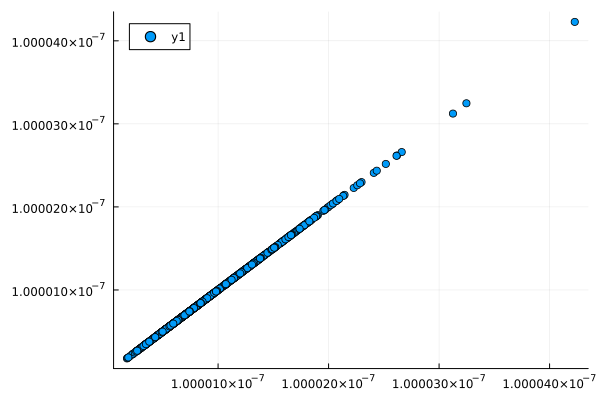

In [73]:
X = [rand(1:2, length(B)) for _ in 1:1000]
error_sample = maximum(abs.([evaluate(B,x) for x in X] .- [1/evaluate(B1,x) for x in X]))
avg_error = mean(abs.([evaluate(B,x) for x in X] .- [1/evaluate(B1,x) for x in X]))
println(avg_error)
println(error_sample)
scatter([evaluate(B,x) for x in X], [1/evaluate(B1,x) for x in X])